# Amperon Data Engineering Take Home Assignment

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import os
from IPython.display import Markdown

postgres_uri = os.environ.get("POSTGRES_URI")
engine = create_engine(postgres_uri)

## Query 1: Latest temperature and wind speed for each geolocation

In [2]:
latest_weather_query = """
SELECT 
    latitude,
    longitude,
    temperature AS latest_temperature,
    wind_speed AS latest_wind_speed,
    snapshot_time AS latest_snapshot_time
FROM (
    SELECT 
        latitude,
        longitude,
        temperature,
        wind_speed,
        snapshot_time,
        ROW_NUMBER() OVER (PARTITION BY latitude, longitude ORDER BY snapshot_time DESC) AS row_num
    FROM bronze_data.weather_history_forecast
) latest_data
WHERE row_num = 1;

"""

latest_weather = pd.read_sql(latest_weather_query, engine)
Markdown(latest_weather.to_markdown(index=False))

|   latitude |   longitude |   latest_temperature |   latest_wind_speed | latest_snapshot_time   |
|-----------:|------------:|---------------------:|--------------------:|:-----------------------|
|      25.86 |      -97.42 |                17.87 |                2.87 | 2024-11-30 03:00:00    |
|      25.9  |      -97.52 |                17.39 |                2.72 | 2024-11-30 03:00:00    |

## Query 2: Hourly time series of temperature for a specific location

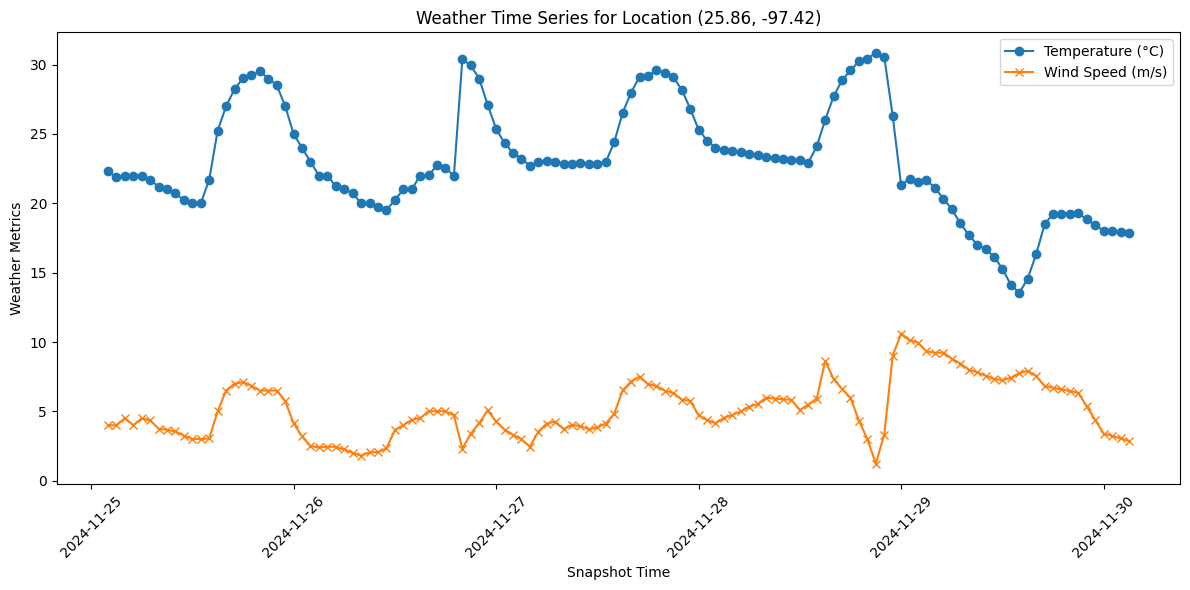

In [3]:
location_lat = 25.86
location_lon = -97.42

time_series_query = f"""
SELECT snapshot_time, temperature, wind_speed
FROM bronze_data.weather_history_forecast
WHERE latitude = {location_lat} AND longitude = {location_lon}
  AND snapshot_time BETWEEN NOW() - INTERVAL '1 day' AND NOW() + INTERVAL '5 days'
ORDER BY snapshot_time;
"""

time_series = pd.read_sql(time_series_query, engine)

# Plotting the time series
plt.figure(figsize=(12, 6))
plt.plot(time_series["snapshot_time"], time_series["temperature"], label="Temperature (°C)", marker="o")
plt.plot(time_series["snapshot_time"], time_series["wind_speed"], label="Wind Speed (m/s)", marker="x")
plt.xlabel("Snapshot Time")
plt.ylabel("Weather Metrics")
plt.title(f"Weather Time Series for Location ({location_lat}, {location_lon})")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()